# Convex Hull Algorithm Performance Analysis

This notebook aggregates experimental run‑times stored in CSV files and visualizes the performance of two convex‑hull algorithms—**Gift Wrapping** and **Divide & Conquer**—across different data‑set sizes and test configurations.

**Assumptions**

* All CSV files live in the same directory as this notebook (or in a sub‑folder you can set in `DATA_DIR` below).
* Filenames follow the pattern described in the project read‑me:
  ```
  <DataType><TestType>Test[_<HullPercent>_<ColinearCount>].csv
  ```
  where  
  * `DataType` ∈ {`Integer`, `Double`, `Float`, `LL`}  
  * `TestType` ∈ {`Random`, `AtLeastThreeColinear`, `Hull`}  
  * The final `_<HullPercent>_<ColinearCount>` segment appears **only** for `*HullTest` files.

Feel free to adapt the glob pattern or paths if your files live elsewhere.

In [7]:
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

# ⬇️ Folder where CSVs reside
DATA_DIR = Path('./data')      # change if your data live elsewhere

# Regular expression to parse filenames
FILENAME_RE = re.compile(
    rf'^(?P<dtype>Integer|Double|LL|Float)'
    rf'(?P<test>Hull|AtLeastThreeColinear|Random)Test'
    rf'(?:_(?P<pct>0\.01|0\.1|1\.0|10|30|50|70|100)_(?P<colinear>0|3|10))?'
    rf'\.csv$'
)

DATA_TYPES = ["Integer", "Double", "LL", "Float"]
PERCENTAGES = [0.01, 0.1, 1.0, 10, 30, 50, 70, 100]
COLINEAR = [0, 3, 10]
SIZES = ['10000', '100000', '1000000']          # point‑set sizes recorded
records = []                                    # final tidy table

for csv_path in DATA_DIR.rglob('*.csv'):
    m = FILENAME_RE.match(csv_path.name)
    if not m:
        # Skip files that do not match the expected convention
        continue

    meta = m.groupdict()
    df = pd.read_csv(csv_path)

    # average over runs for each algorithm & size
    for size in SIZES:
        for algo in ['GiftWrapping', 'DivideAndConquer']:
            col = f'{size}{algo}'
            if col not in df.columns:
                continue
            records.append({
                'dtype'      : meta['dtype'],
                'test'       : meta['test'],
                'pct'        : float(meta['pct']) if meta['pct'] else None,
                'colinear'   : int(meta['colinear']) if meta['colinear'] else None,
                'size'       : int(size),
                'algorithm'  : algo,
                'avg_time_ms': df[col].mean()
            })

results = pd.DataFrame(records)
display(results.head())

,dtype,test,pct,colinear,size,algorithm,avg_time_ms
0,Double,AtLeastThreeColinear,NaN,NaN,10000,GiftWrapping,40.43432
1,Double,AtLeastThreeColinear,NaN,NaN,10000,DivideAndConquer,13.28302
2,Double,AtLeastThreeColinear,NaN,NaN,100000,GiftWrapping,531.80060
3,Double,AtLeastThreeColinear,NaN,NaN,100000,DivideAndConquer,124.45320
4,Double,AtLeastThreeColinear,NaN,NaN,1000000,GiftWrapping,5343.23200


## Overall comparison (Random & AtLeastThreeColinear)

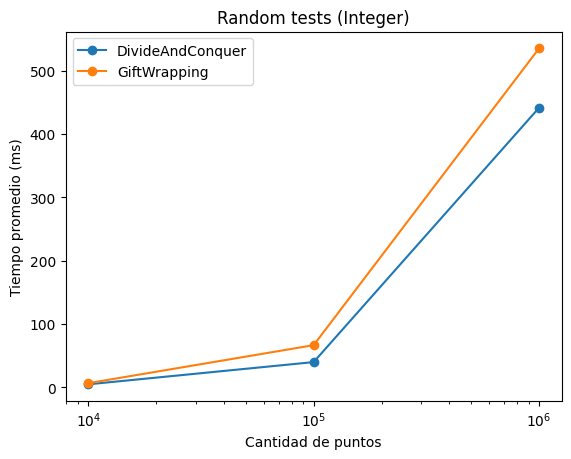

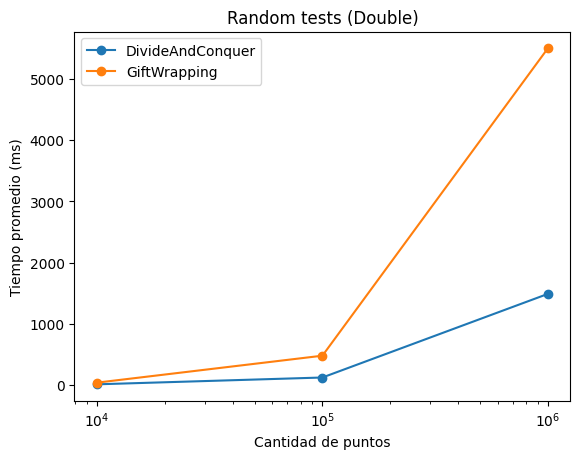

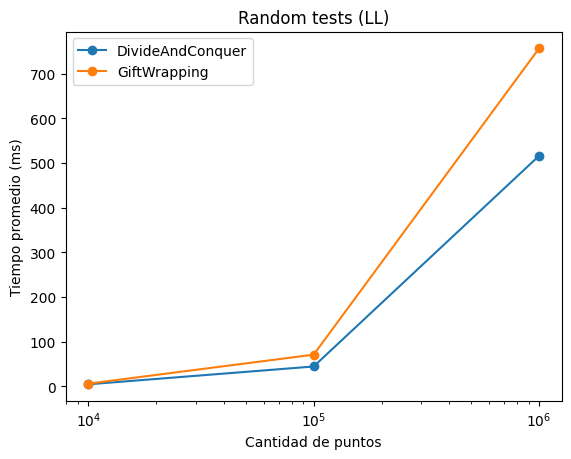

C:\Users\Tchy\AppData\Local\Temp\ipykernel_14796\22336109.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


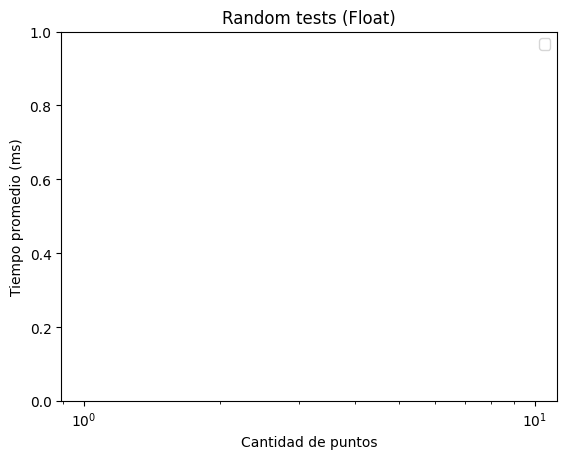

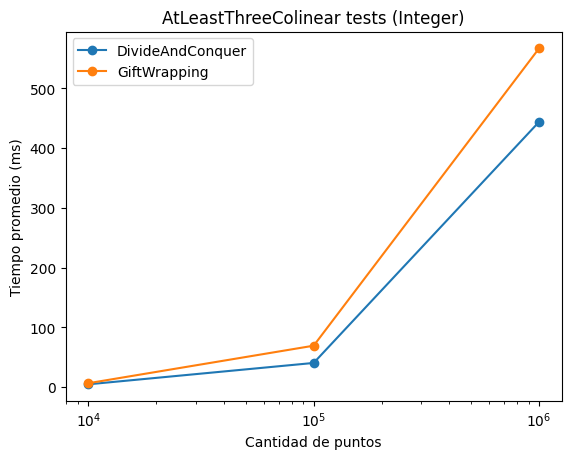

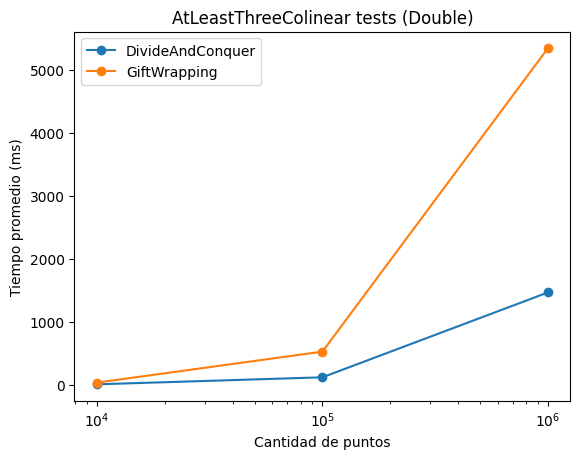

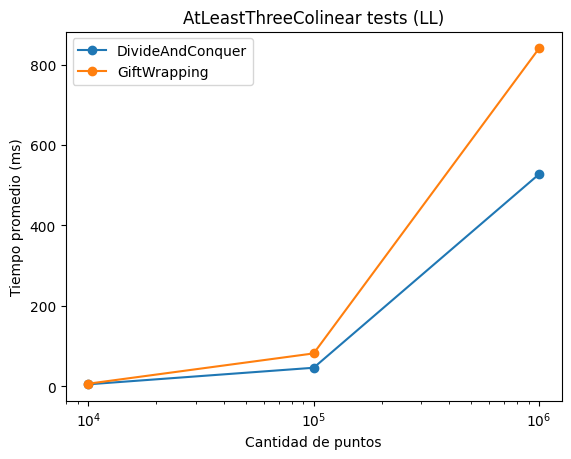

C:\Users\Tchy\AppData\Local\Temp\ipykernel_14796\22336109.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


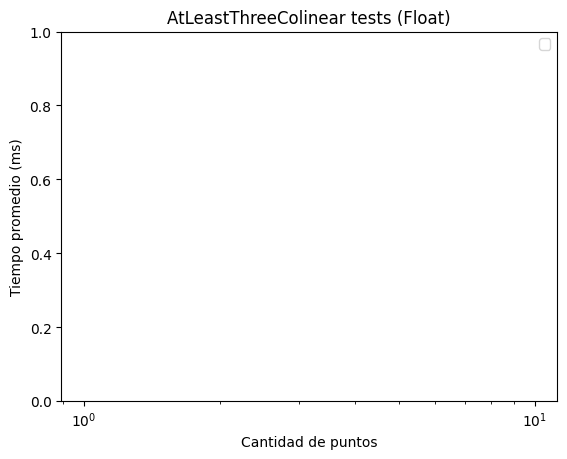

In [8]:
# Separate plots for Random and AtLeastThreeColinear
non_hull = results[results['test'] != 'Hull']

for test_type in ['Random', 'AtLeastThreeColinear']:
    for data_type in DATA_TYPES:
        fig, ax = plt.subplots()
        subset = non_hull[non_hull['test'] == test_type]
        subset = subset[subset["dtype"] == data_type]
        for algo, df_algo in subset.groupby('algorithm'):
            pivot = df_algo.groupby('size')['avg_time_ms'].mean().reset_index()
            ax.plot(pivot['size'], pivot['avg_time_ms'], marker='o', label=algo)
        ax.set_xscale('log')
        ax.set_xlabel('Cantidad de puntos')
        ax.set_ylabel('Tiempo promedio (ms)')
        ax.set_title(f'{test_type} tests ({data_type})')
        ax.legend()
        plt.show()

## Hull‑test parameter sweeps

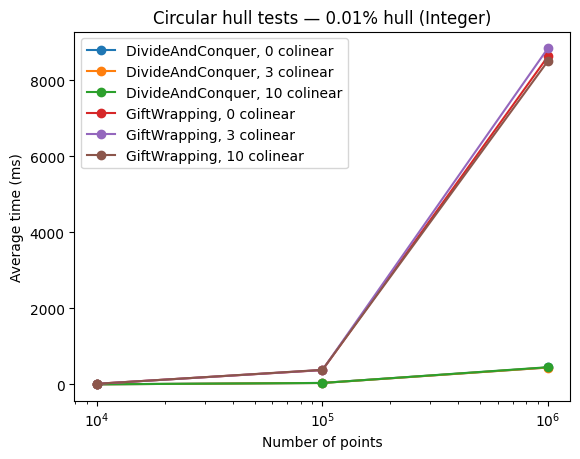

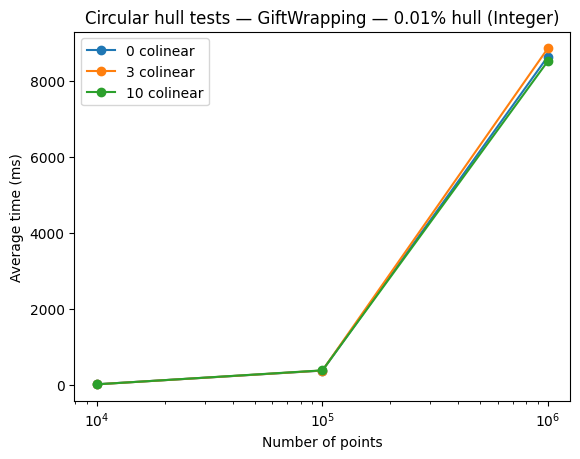

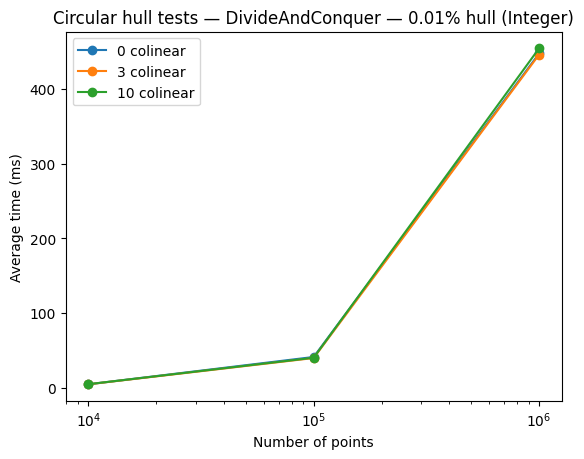

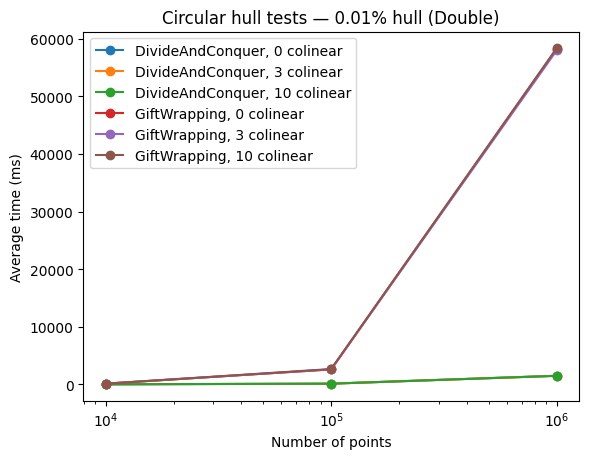

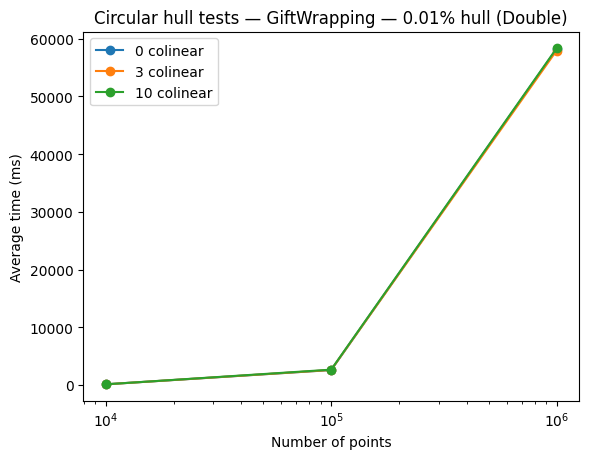

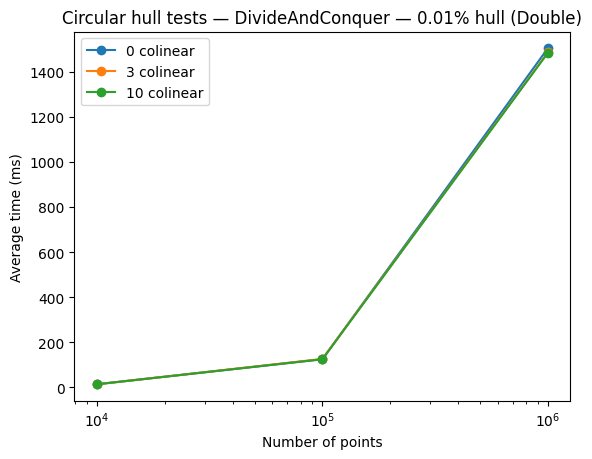

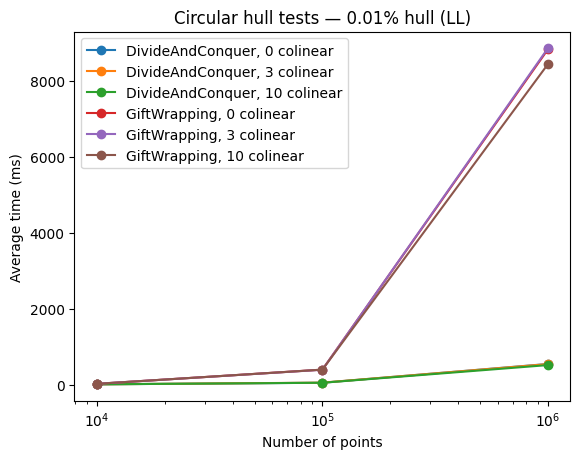

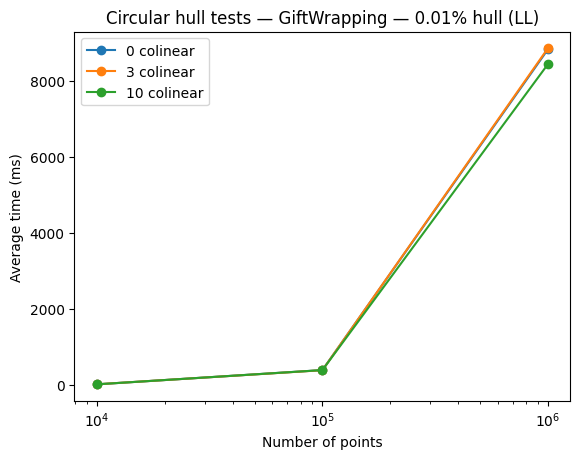

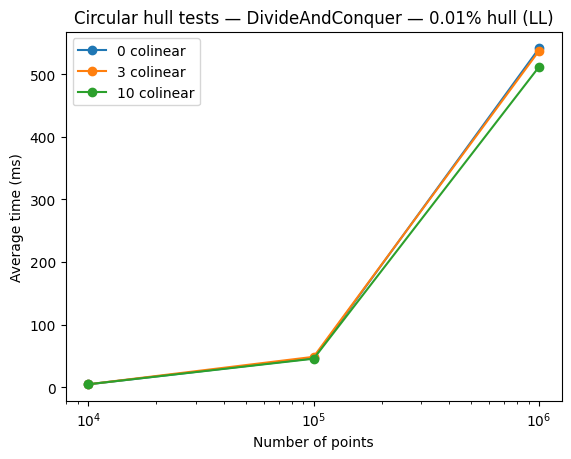

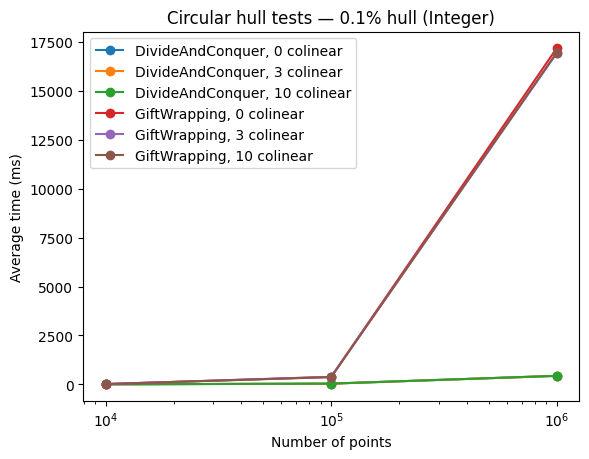

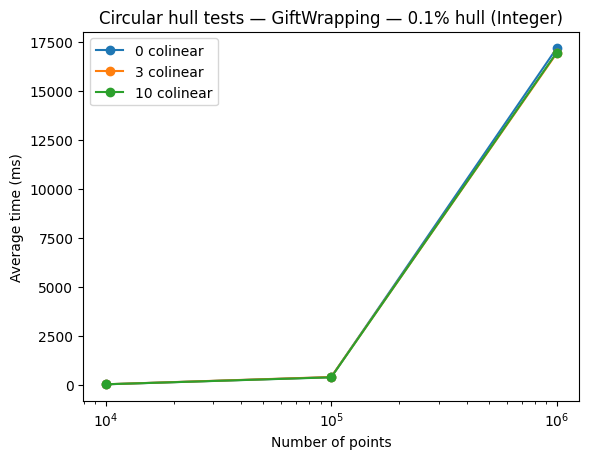

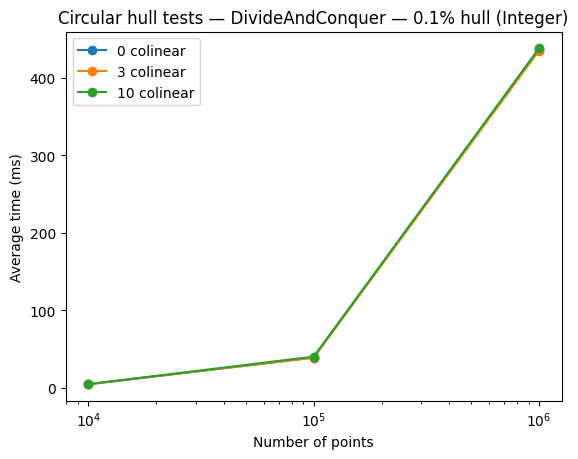

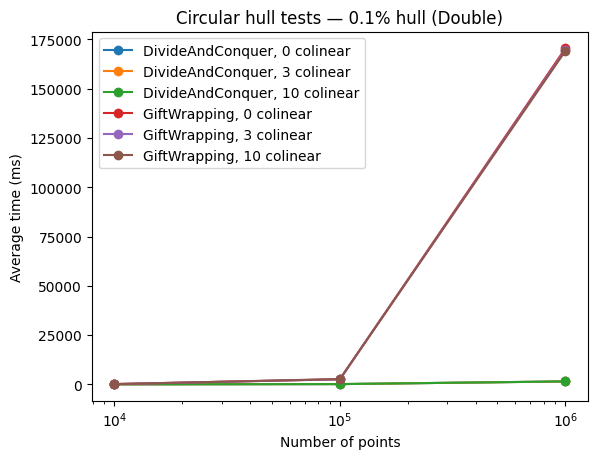

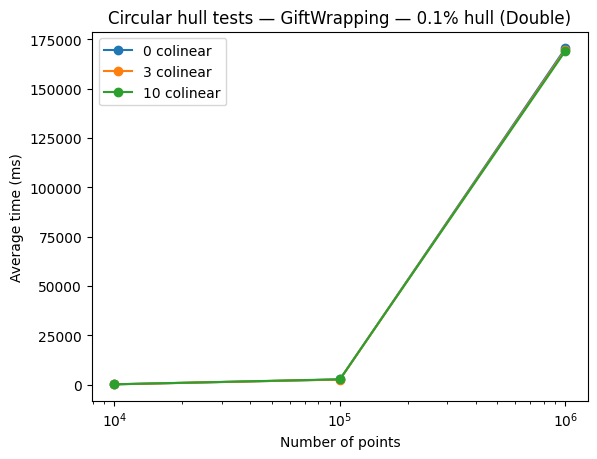

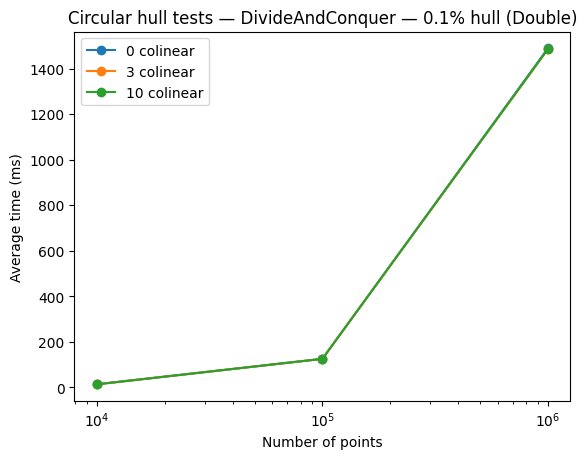

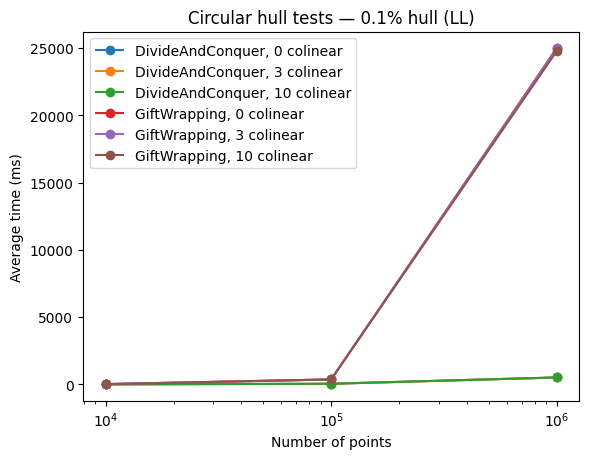

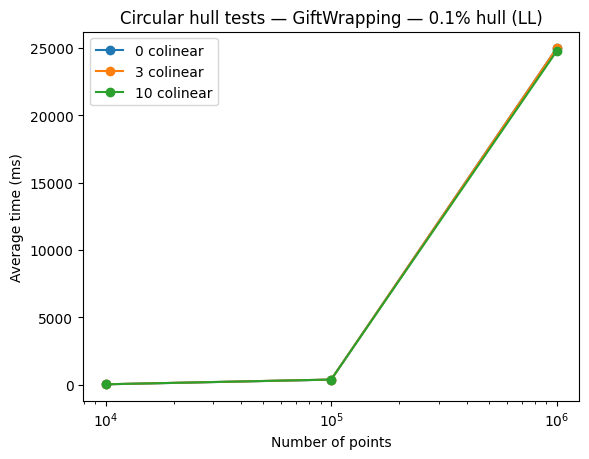

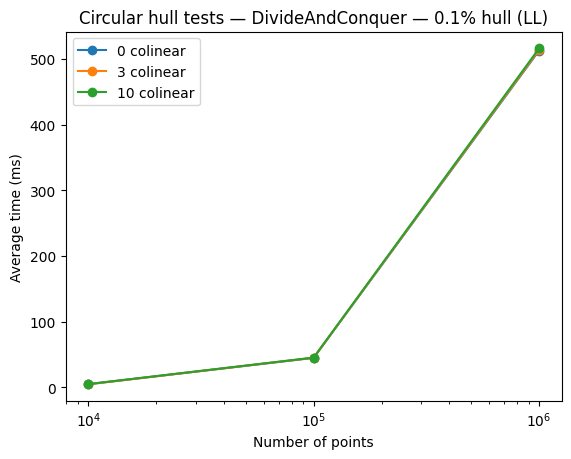

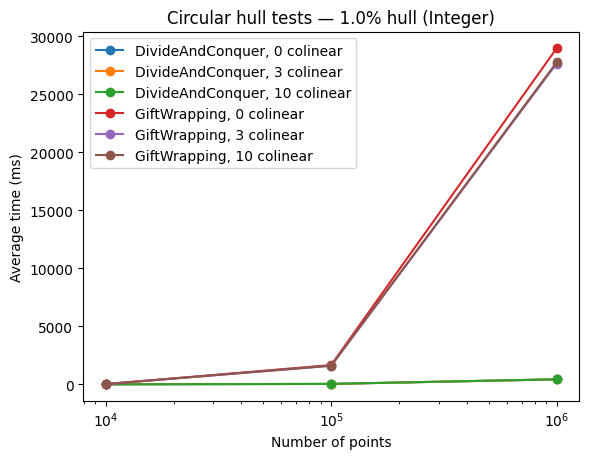

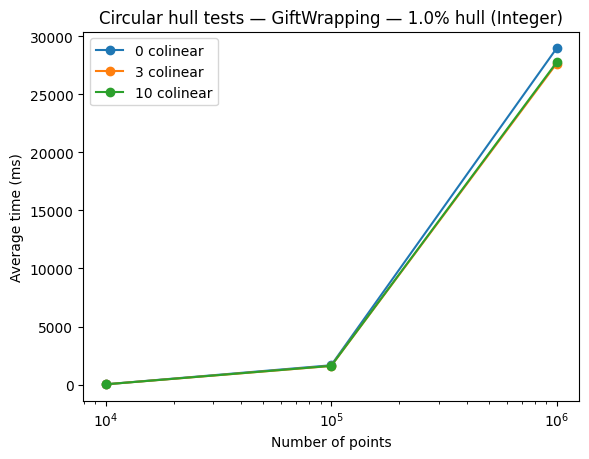

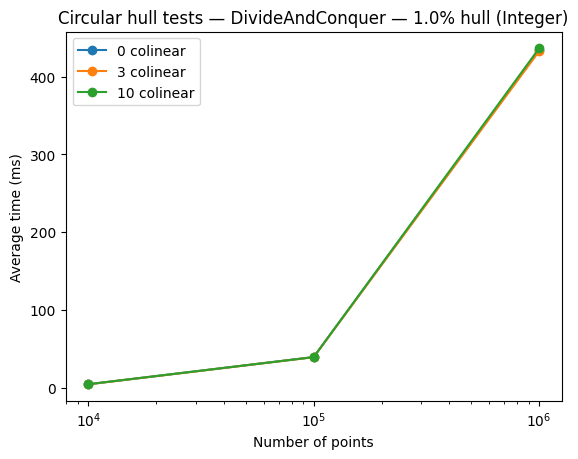

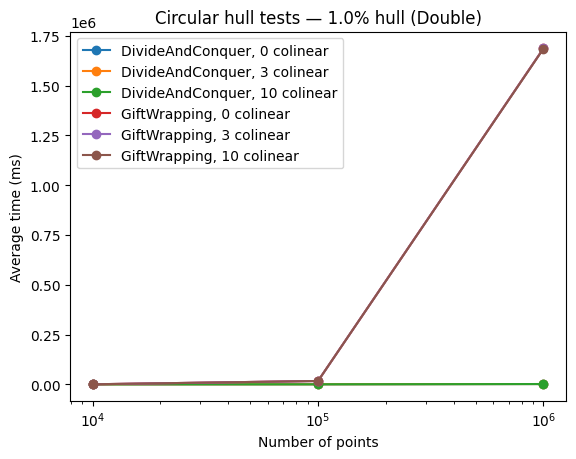

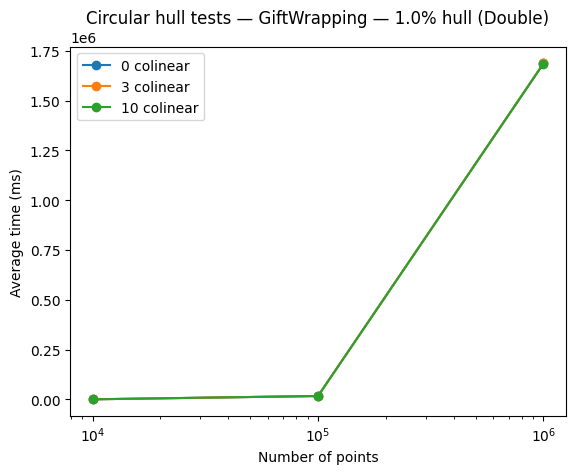

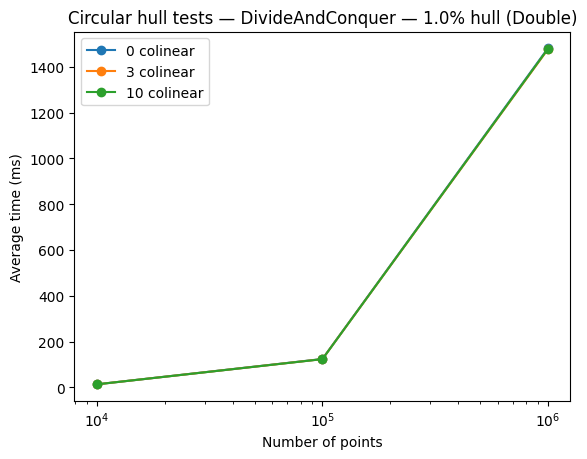

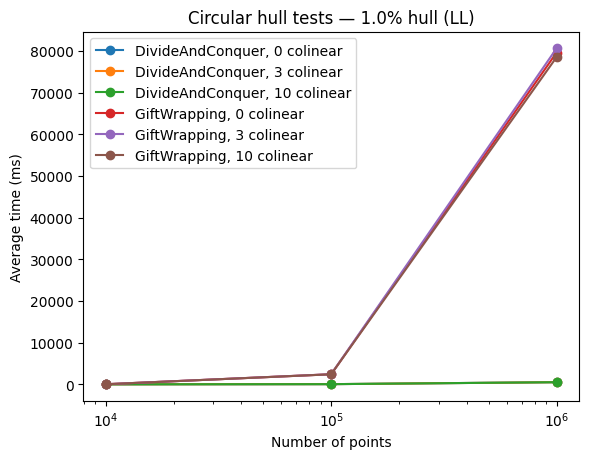

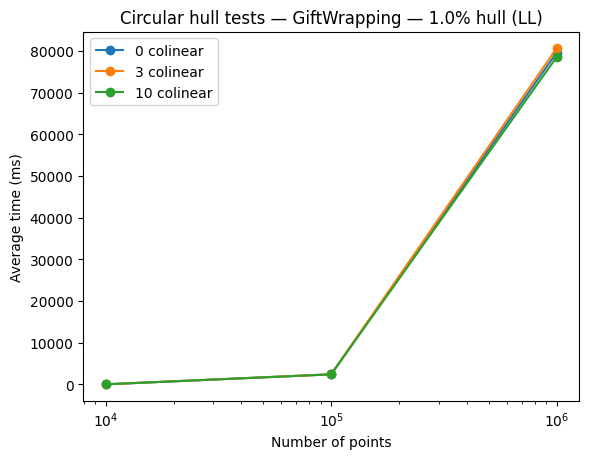

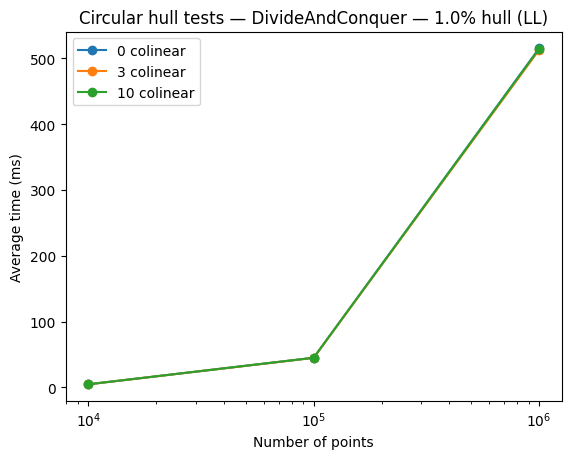

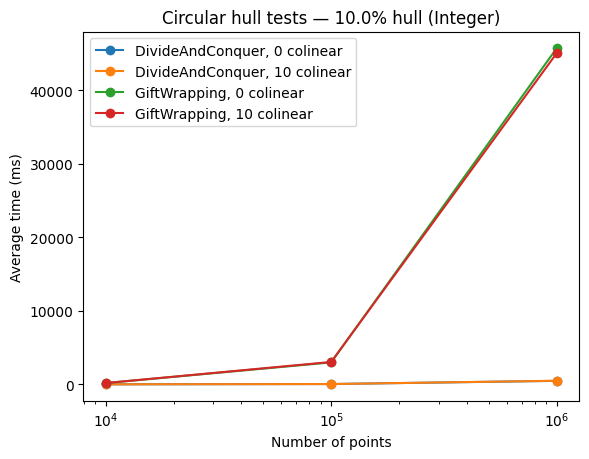

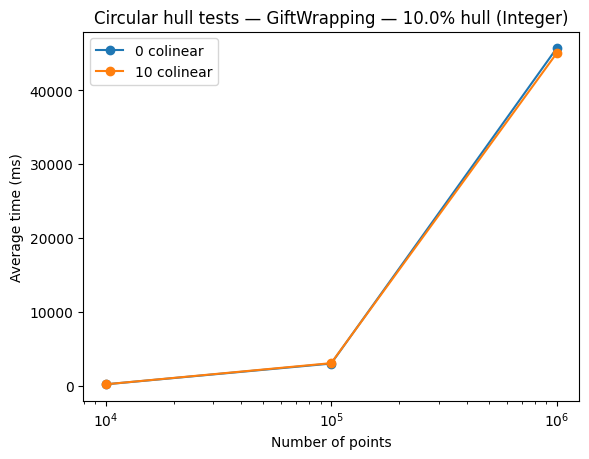

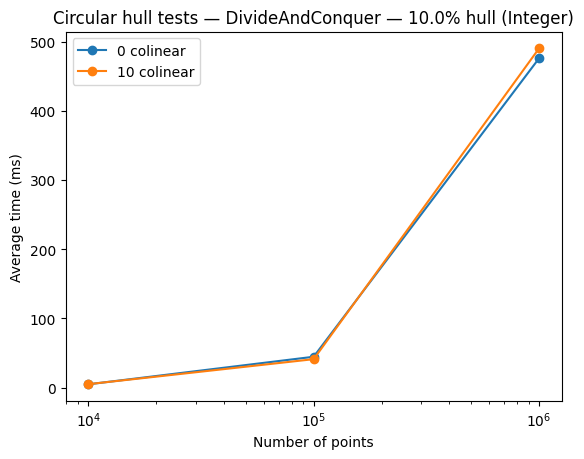

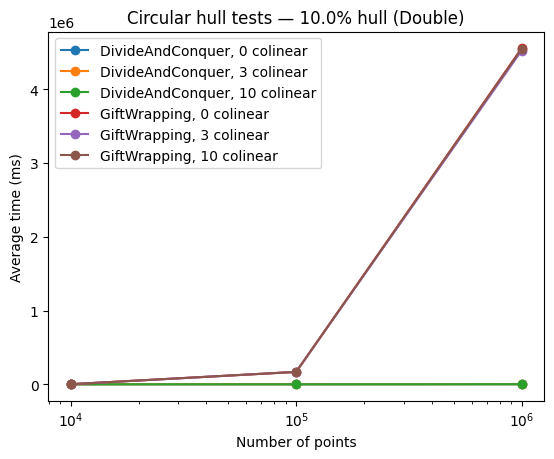

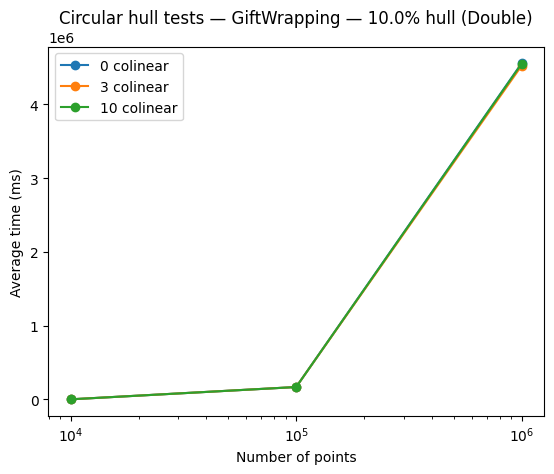

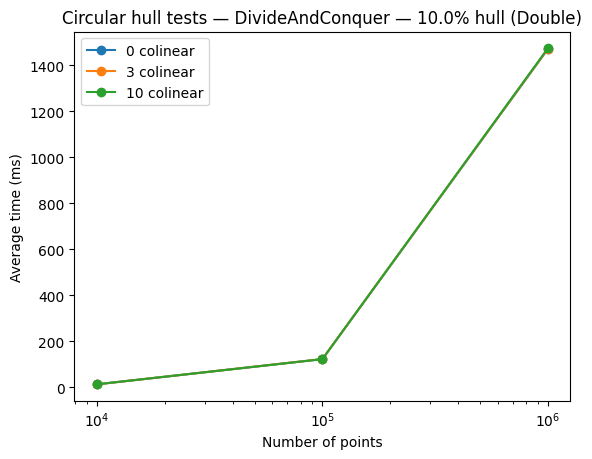

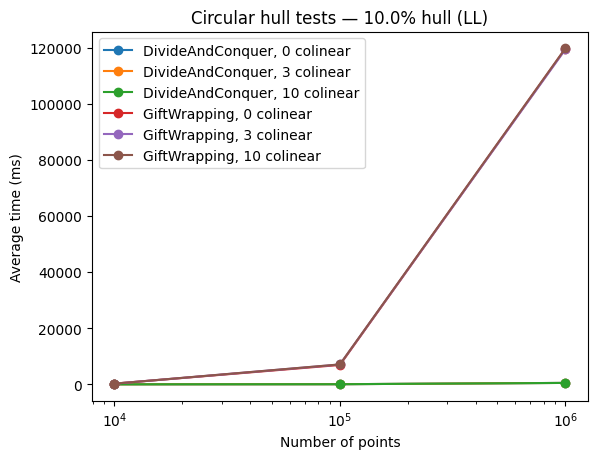

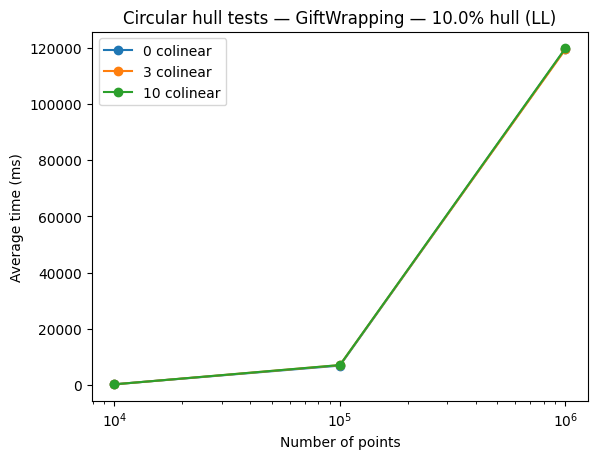

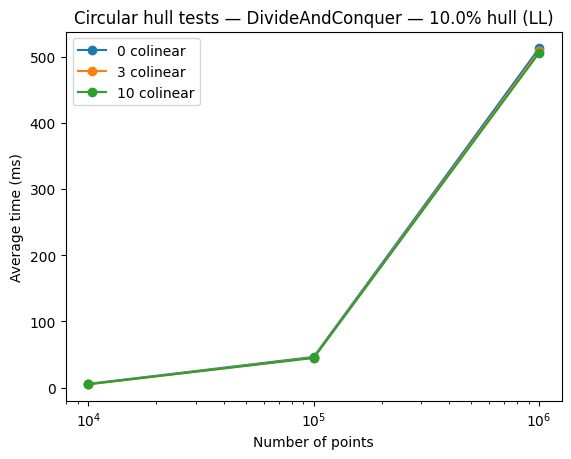

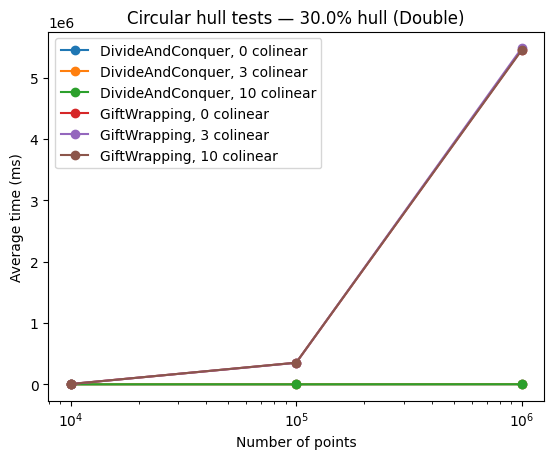

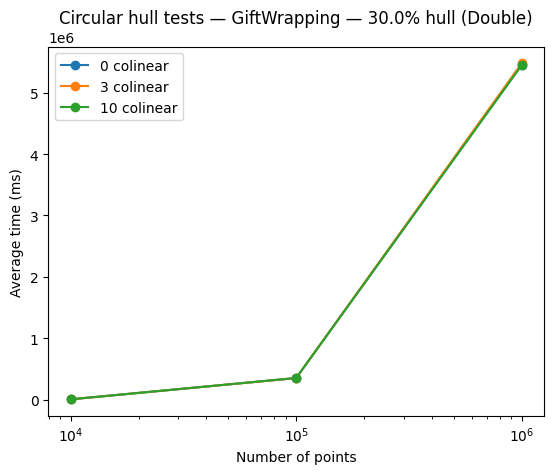

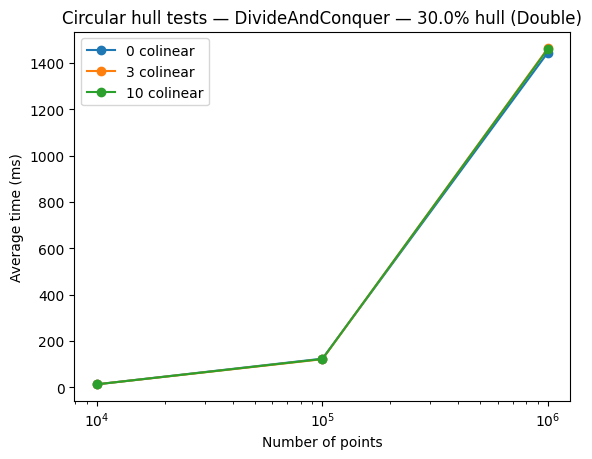

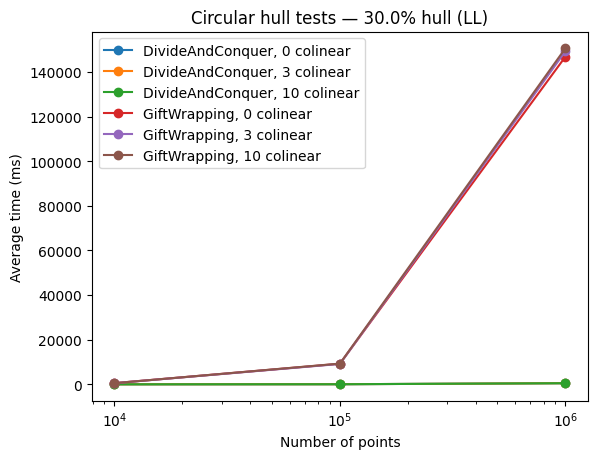

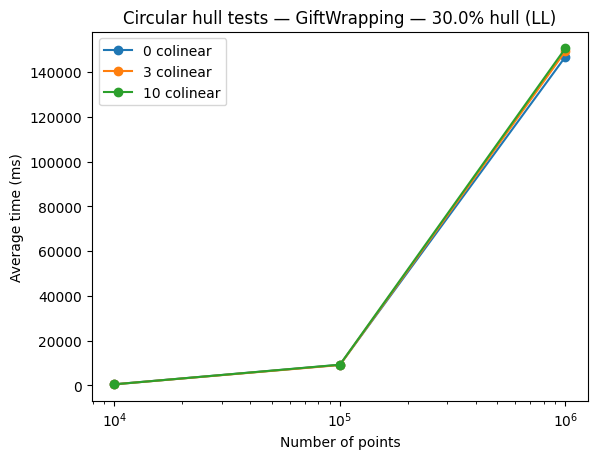

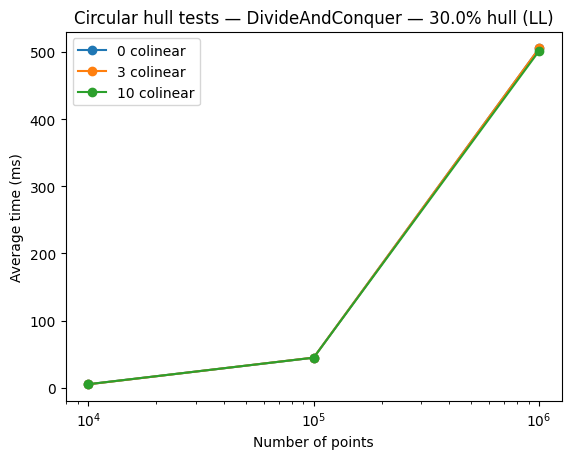

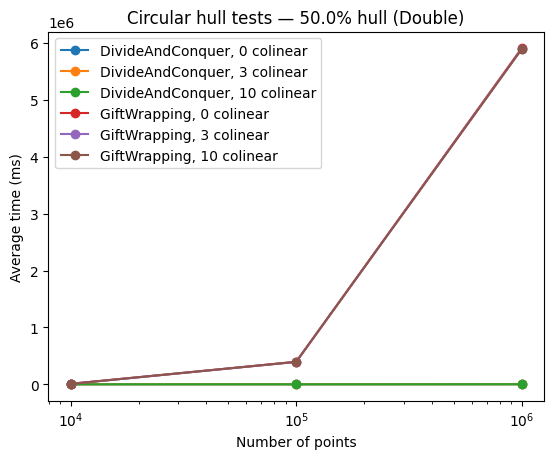

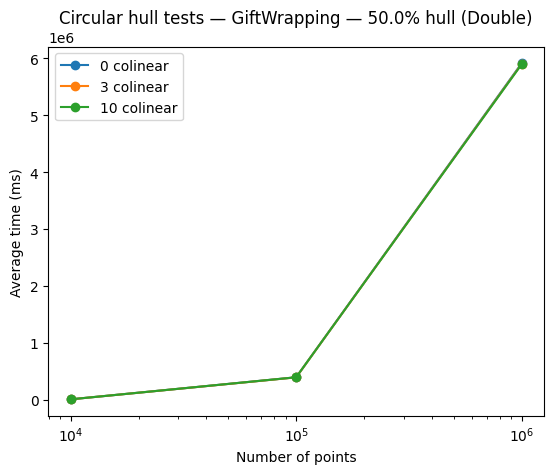

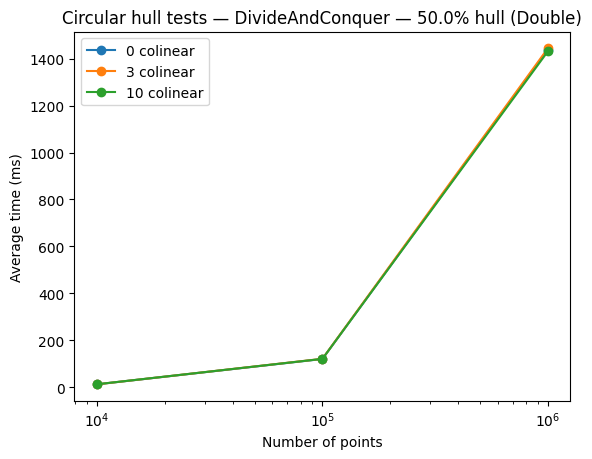

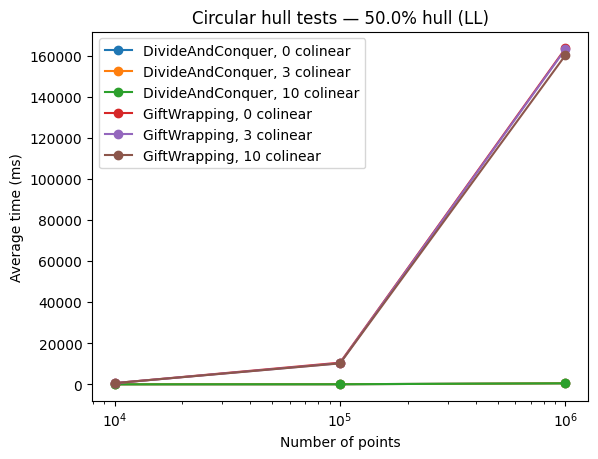

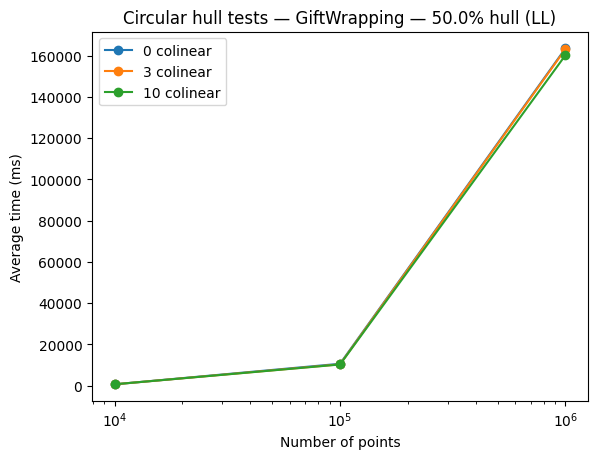

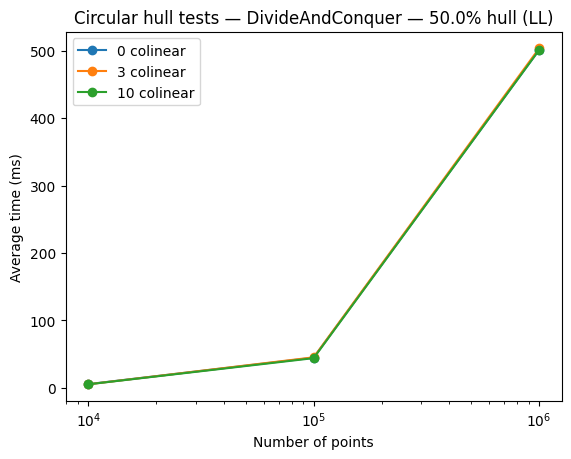

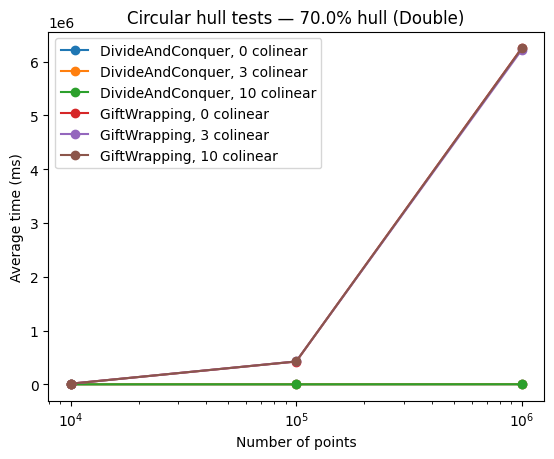

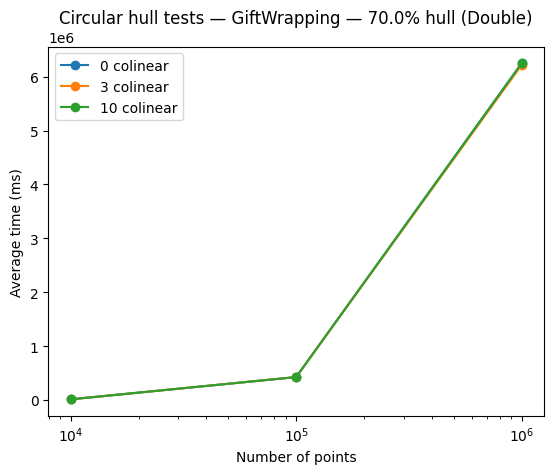

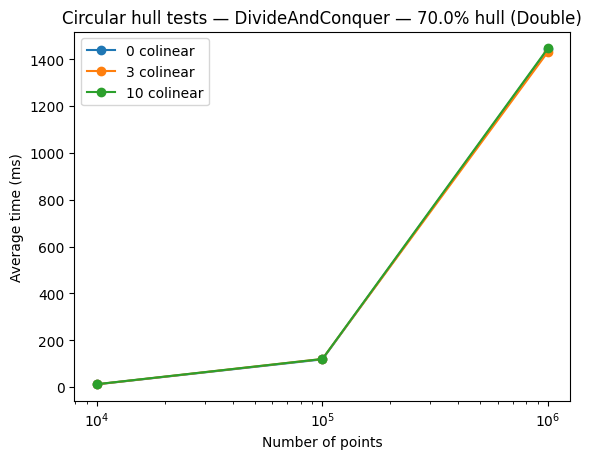

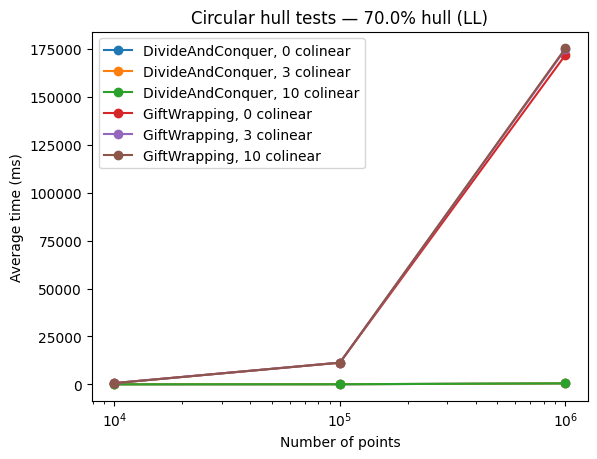

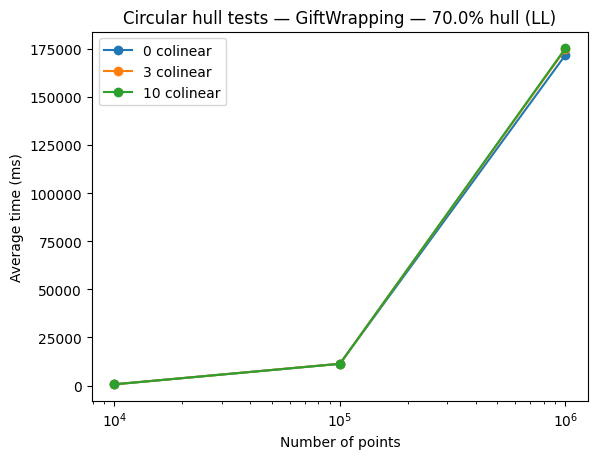

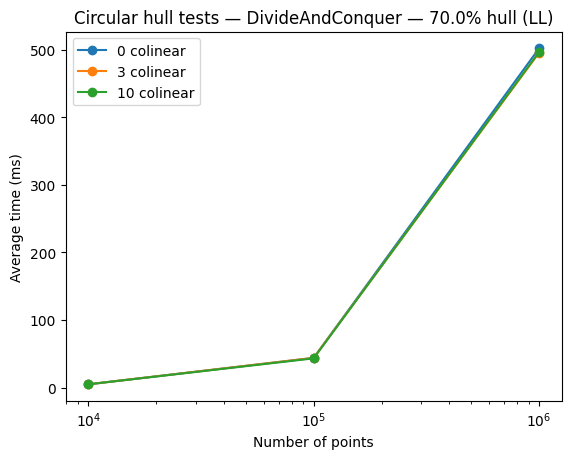

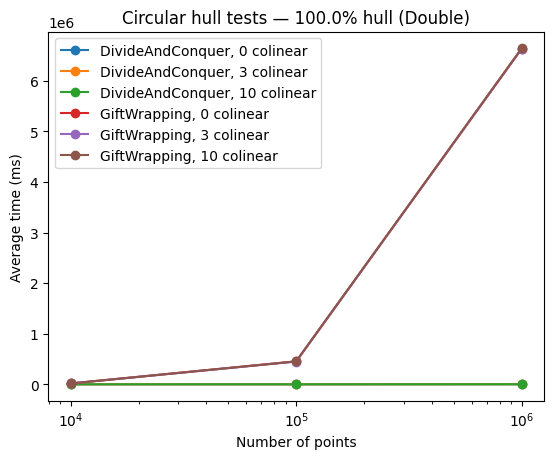

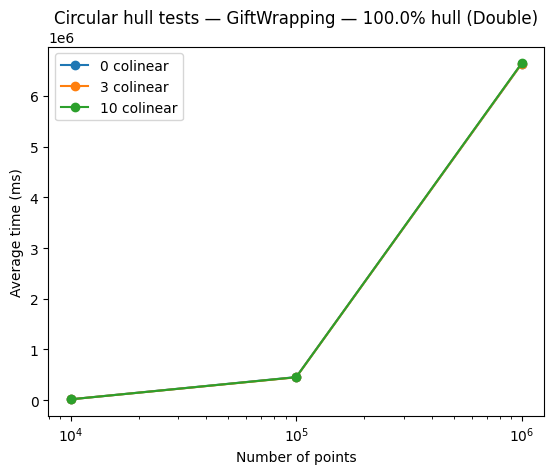

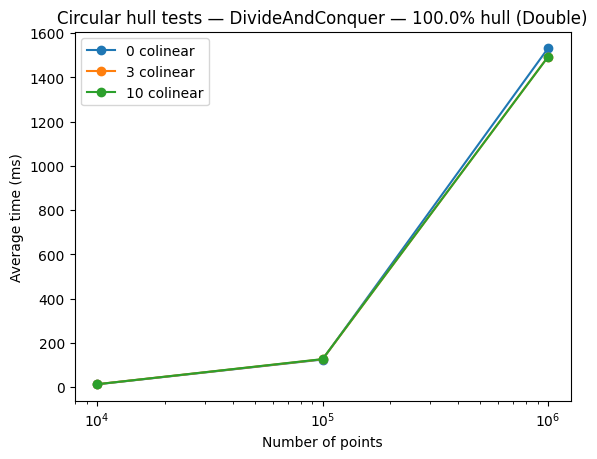

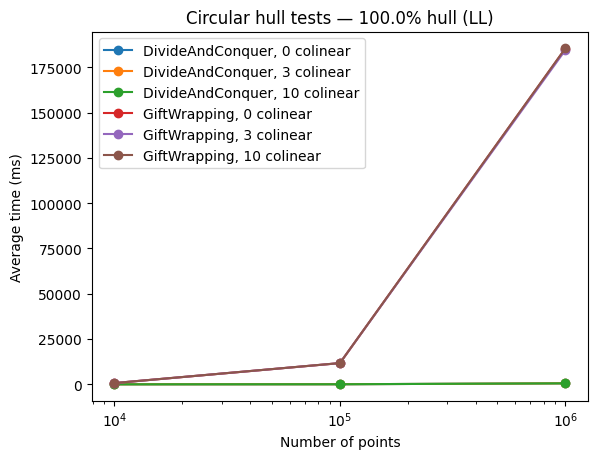

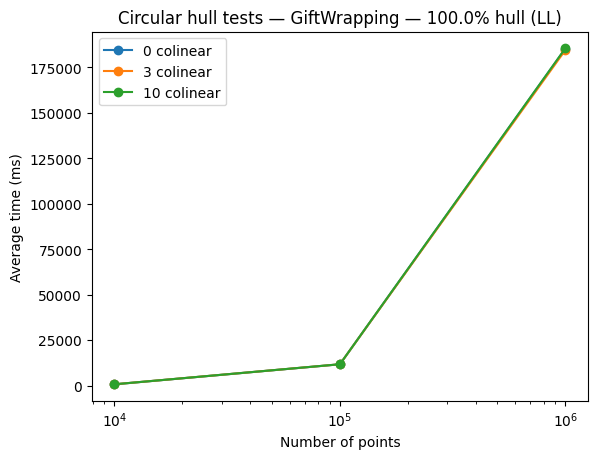

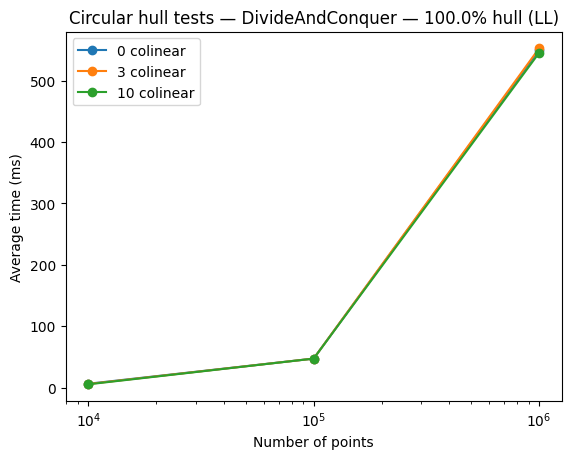

In [ ]:
hull = results[results['test'] == 'Hull']
if hull.empty:
    print('⚠️ No *HullTest CSVs found — skipping this section.')
else:
    for pct in sorted(hull['pct'].dropna().unique()):
        for data_type in DATA_TYPES:
            fig, ax = plt.subplots()
            subset = hull[(hull['pct'] == pct) & (hull["dtype"] == data_type)]
            if subset.empty: 
                plt.close(fig)
                continue
            for (algo, col), df_group in subset.groupby(['algorithm', 'colinear']):
                label = f'{algo}, {int(col)} colinear'
                pivot = df_group.groupby('size')['avg_time_ms'].mean().reset_index()
                ax.plot(pivot['size'], pivot['avg_time_ms'], marker='o', label=label)
            ax.set_xscale('log')
            ax.set_xlabel('Number of points')
            ax.set_ylabel('Average time (ms)')
            ax.set_title(f'Circular hull tests — {pct}% hull ({data_type})')
            ax.legend()
            plt.show()
            fig.savefig(f'./hull_{data_type}_{pct}%.svg',bbox_inches='tight')
            for algo in hull['algorithm'].unique():
                fig, ax = plt.subplots()
                subset2 = hull[(hull['pct'] == pct) & (hull['algorithm'] == algo) & (hull["dtype"] == data_type)]
                for col, df_col in subset2.groupby('colinear'):
                    label = f'{int(col)} colinear'
                    pivot = df_col.groupby('size')['avg_time_ms'].mean().reset_index()
                    ax.plot(pivot['size'], pivot['avg_time_ms'], marker='o', label=label)
                ax.set_xscale('log')
                ax.set_xlabel('Number of points')
                ax.set_ylabel('Average time (ms)')
                ax.set_title(f'Circular hull tests — {algo} — {pct}% hull ({data_type})')
                ax.legend()
                plt.show()
                fig.savefig(f'./hull_{data_type}_{pct}%_{algo}.svg',bbox_inches='tight')